<a href="https://colab.research.google.com/github/uncbiag/OAI_analysis_2/blob/pranjal3/notebooks/DaskComputationCoiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages

# Remember to Restart runtime after installation


!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets
!pip install icon-registration==0.3.4
!pip install tornado==6.1
!pip install coiled
!pip install torch
!pip install jupyter
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install git+https://github.com/PranjalSahu/OAI_analysis_2.git#egg=oai_package

In [1]:
# All Imports

import coiled
import dask
from dask import compute, visualize, delayed

import itk
import vtk
import itkwidgets
from oai_analysis_2 import dask_processing as dp

import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
# To create a software environment using docker with open gl installed
import coiled
coiled.create_software_environment(
    name="oai13",
    container="pranjalsahu/pranjal-sahu-oai7:latest",
)

Invalid Coiled token encountered. You can create new tokens and manage your existing ones at 
https://cloud.coiled.io/profile.

Please login to https://cloud.coiled.io/profile to get your token

Token: ··········


Authentication successful

Save credentials for next time? [Y/n]: Y


Credentials have been saved at /root/.config/dask/coiled.yaml

Creating new software environment
Creating container-only software environment
Successfully saved software environment build


In [3]:
# Create Dask Client. This will also spawn dask worker and scheduler

name = 'oai-processing11'
cluster = coiled.Cluster(n_workers=2,
                        name=name,
                        worker_vm_types=['c5a.4xlarge'],
                        scheduler_vm_types=['t3.medium'],
                        software='pranjal-sahu/oai13')
client = dask.distributed.Client(cluster, 
                                  serializers=['pickle', 'dask'],
                                  deserializers=['pickle', 'dask'])
print(client)

Output()

<Client: 'tls://172.18.0.2:8786' processes=0 threads=0, memory=0 B>


In [4]:
# Main execution block

phi_AB, image_A, image_B = dp.register_images_delayed()
deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, 'FC')
deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B, 'TC')

thickness_fc = dp.get_thickness(deformed_fc, 'FC')
thickness_tc = dp.get_thickness(deformed_tc, 'TC')

result = [thickness_fc, thickness_tc]

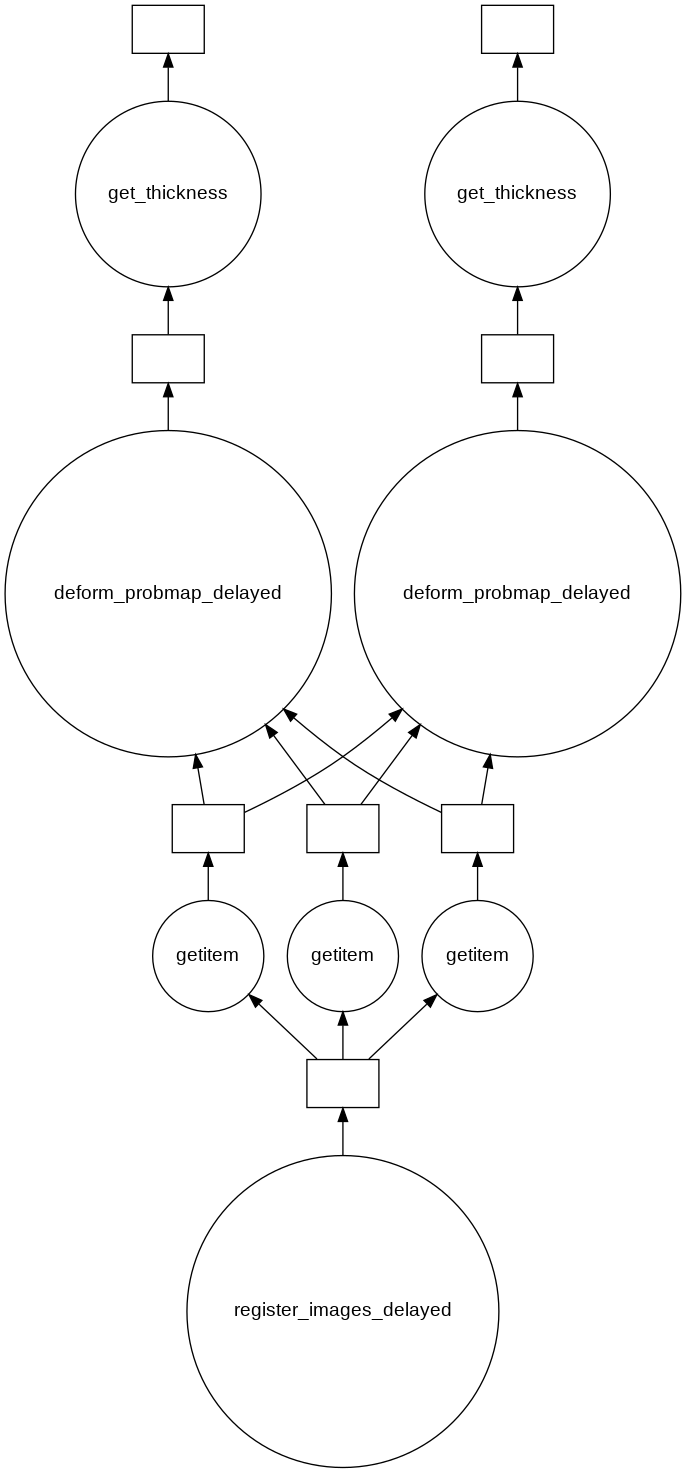

In [5]:
# Visualize Dask Computation Graph

visualize(result)

In [8]:
# Perform Computation

output_result = compute(*result)

In [204]:
#cluster.close()

In [9]:
# Write the meshes as vtk files

m1 = itk.mesh_from_dict(output_result[0])
m2 = itk.mesh_from_dict(output_result[1])

itk.meshwrite(m1, 'm1.vtk')
itk.meshwrite(m2, 'm2.vtk')

In [10]:
# Read the meshes for viewing

v1 = vtk.vtkPolyDataReader()
v1.SetFileName('m1.vtk')
v1.Update()
m1 = v1.GetOutput()

v2 = vtk.vtkPolyDataReader()
v2.SetFileName('m2.vtk')
v2.Update()
m2 = v2.GetOutput()

In [11]:
# Visualize the meshes

from google.colab import output
output.enable_custom_widget_manager()

itkwidgets.view(geometries=[m1, m2])


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…